<a href="https://colab.research.google.com/github/ronald-hk-chung/torch-step/blob/main/UTK_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTK Face Detection Exercise

### Description of dataset
https://www.kaggle.com/datasets/jangedoo/utkface-new?select=crop_part1
UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.

https://susanqq.github.io/UTKFace/


## Import necessary Libaries

In [17]:
import datetime
import random
import os, pathlib, shutil
from pathlib import Path
import zipfile
import gdown
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import datasets, transforms
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, Dataset
from torch import nn
try:
  import torchinfo
except:
  !pip install -q torchinfo
  import torchinfo

TS_URL = 'https://raw.githubusercontent.com/ronald-hk-chung/torch-step/main/torch_step.py'
with open('torch_step.py', 'wb') as f:
  f.write(requests.get(TS_URL).content)
from torch_step import show_batch, TSEngine, get_pretrained_model

## Data Preperation

In [2]:
# Download zip file from gdrive
id = '1H1xp2jixxPfGRJp4Ufr5XAdG3i7P0aJB'
output = 'UTKFace.zip'
gdown.download(id=id, output=output, quiet=False)

# Unzip to data to raw_data folder
Path('data').mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
  zip_ref.extractall('data/')

Downloading...
From: https://drive.google.com/uc?id=1H1xp2jixxPfGRJp4Ufr5XAdG3i7P0aJB
To: /content/UTKFace.zip
100%|██████████| 120M/120M [00:07<00:00, 16.1MB/s]


In [42]:
#Prepare DF for data
data_dir = Path('data/UTKFace')
data_paths = list(data_dir.rglob('*.jpg'))

In [136]:
def get_limiter(path, limiter):
  return [pos for pos, char in enumerate(path.name) if char == limiter]

def get_df(paths):
  path_dict={'path': [],
             'age': [],
             'gender': [],
             'race': []}
  for path in paths:
    limiters = get_limiter(path, '_')
    if len(limiters) == 3:
      path_dict['path'].append(str(path))
      path_dict['age'].append(min(float(path.name[:limiters[0]]),60))
      path_dict['gender'].append(float(path.name[limiters[0]+1:limiters[1]]))
      path_dict['race'].append(float(path.name[limiters[1]+1:limiters[2]]))

  return pd.DataFrame(path_dict)

In [137]:
# Using paths values to put into dataframe
# format [age]_[gender]_[race]_[date&time].jpg
df_uktface = get_df(data_paths)

In [138]:
df_uktface.describe(), df_uktface.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   path    23705 non-null  object 
 1   age     23705 non-null  float64
 2   gender  23705 non-null  float64
 3   race    23705 non-null  float64
dtypes: float64(3), object(1)
memory usage: 740.9+ KB


(                age        gender          race
 count  23705.000000  23705.000000  23705.000000
 mean      31.949589      0.477283      1.269226
 std       17.131973      0.499494      1.345638
 min        1.000000      0.000000      0.000000
 25%       23.000000      0.000000      0.000000
 50%       29.000000      0.000000      1.000000
 75%       45.000000      1.000000      2.000000
 max       60.000000      1.000000      4.000000,
 None)

## Check distribution of dataframe

In [139]:
# Apply train test split in dataframe
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df_uktface, test_size=0.2)

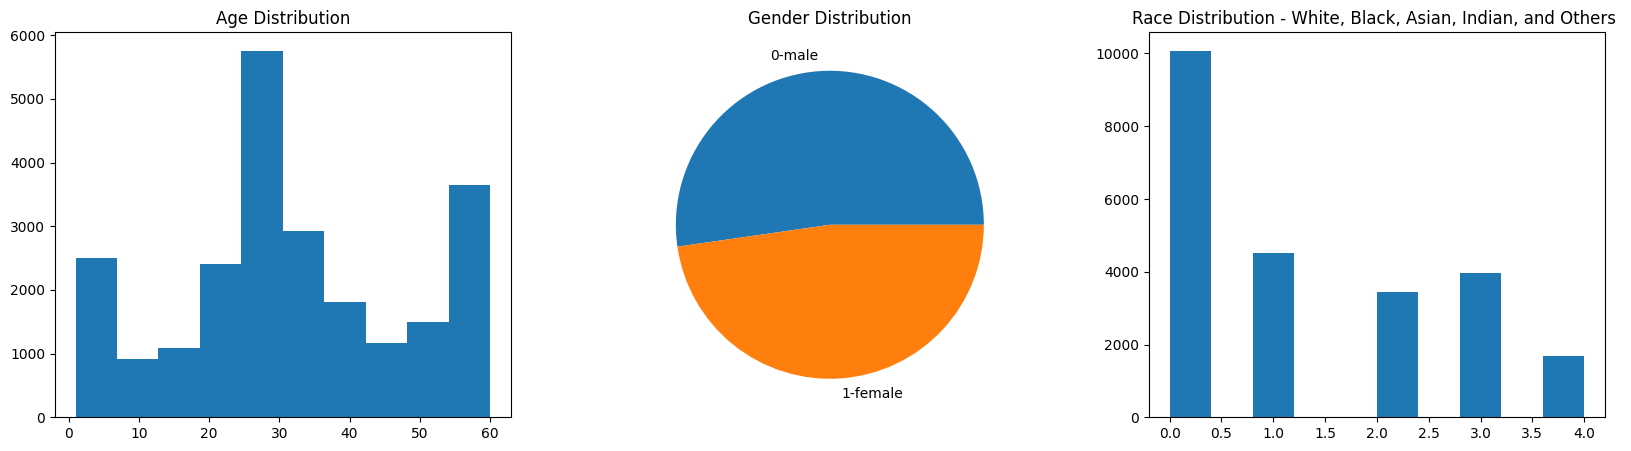

In [141]:
# Check distribution of full data
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.hist(df_uktface['age'])
plt.title('Age Distribution')
plt.subplot(1,3,2)
plt.pie(df_uktface['gender'].value_counts(), labels=['0-male', '1-female'])
plt.title('Gender Distribution')
plt.subplot(1,3,3)
plt.hist(df_uktface['race'])
plt.title('Race Distribution - White, Black, Asian, Indian, and Others ');

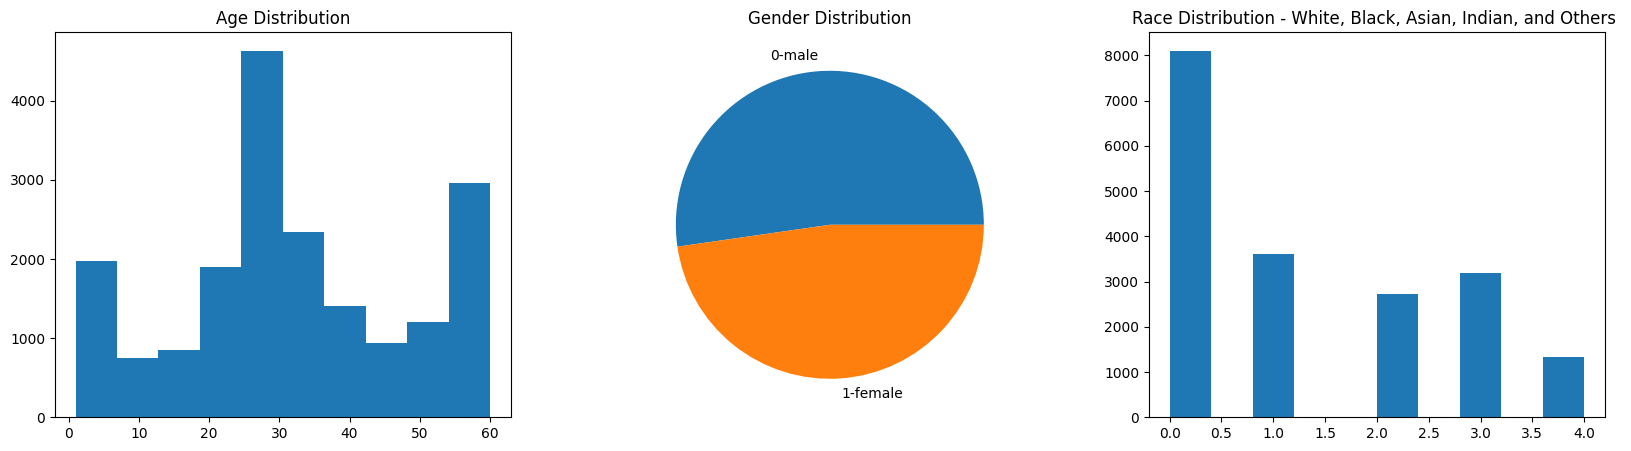

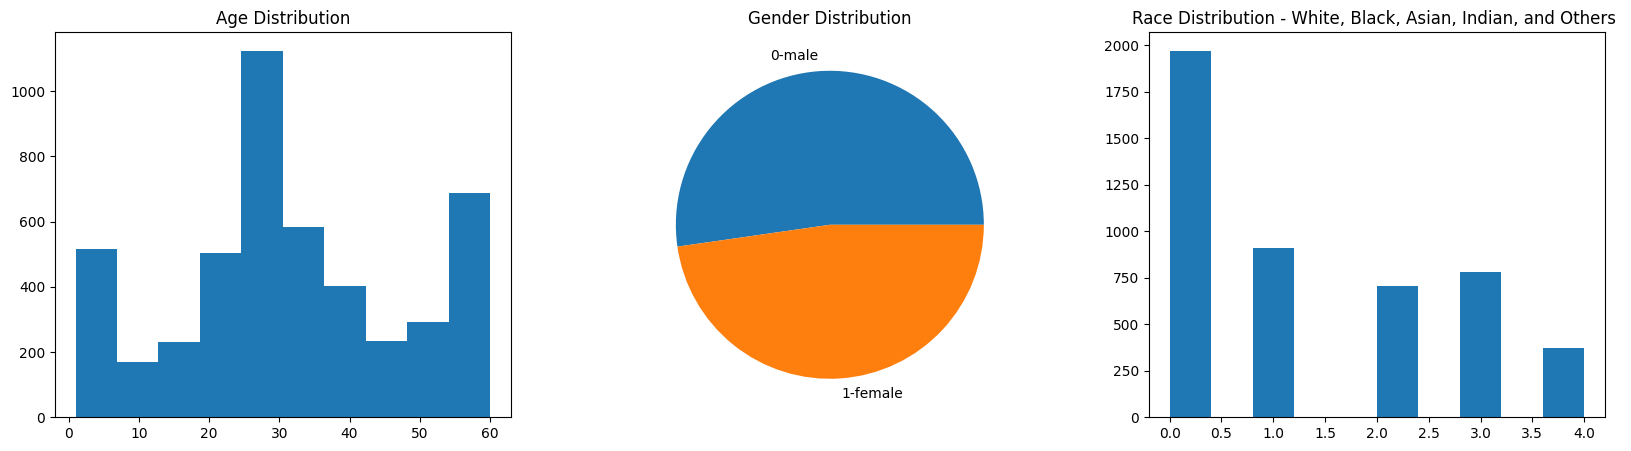

In [142]:
# Check of train data
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.hist(df_train['age'])
plt.title('Age Distribution')
plt.subplot(1,3,2)
plt.pie(df_train['gender'].value_counts(), labels=['0-male', '1-female'])
plt.title('Gender Distribution')
plt.subplot(1,3,3)
plt.hist(df_train['race'])
plt.title('Race Distribution - White, Black, Asian, Indian, and Others ');

# Check of valid data
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.hist(df_valid['age'])
plt.title('Age Distribution')
plt.subplot(1,3,2)
plt.pie(df_valid['gender'].value_counts(), labels=['0-male', '1-female'])
plt.title('Gender Distribution')
plt.subplot(1,3,3)
plt.hist(df_valid['race'])
plt.title('Race Distribution - White, Black, Asian, Indian, and Others ');

## Download pretrained models and transformation - Resnet34

In [143]:
# Download pretrained resnet50
model_resnet34, tfms_resnet34, rtfms_resnet34 = get_pretrained_model(name='resnet34',
                                                            pretrained_weights='ResNet34_Weights.IMAGENET1K_V1')

## Prepare dataset and dataloaders with pretrained_transformation

In [144]:
class AGRDataset(Dataset):
  def __init__(self, df, tfms):
    self.df = df
    self.tfms = tfms
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    img = self.tfms(Image.open(self.df.iloc[idx].path))
    age = torch.tensor(self.df.iloc[idx].age/60, dtype=torch.float32)
    gender = torch.tensor(self.df.iloc[idx].gender, dtype=torch.float32)
    race = torch.tensor(self.df.iloc[idx].race, dtype=torch.int64)
    return img, age, gender, race

In [145]:
train_ds = AGRDataset(df=df_train,
                      tfms=tfms_resnet34)
valid_ds = AGRDataset(df=df_valid,
                      tfms=tfms_resnet34)

train_dl = DataLoader(dataset=train_ds,
                      batch_size=32,
                      shuffle=True,
                      num_workers=os.cpu_count(),
                      pin_memory=True)
valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=32,
                      shuffle=False,
                      num_workers=os.cpu_count(),
                      pin_memory=True)

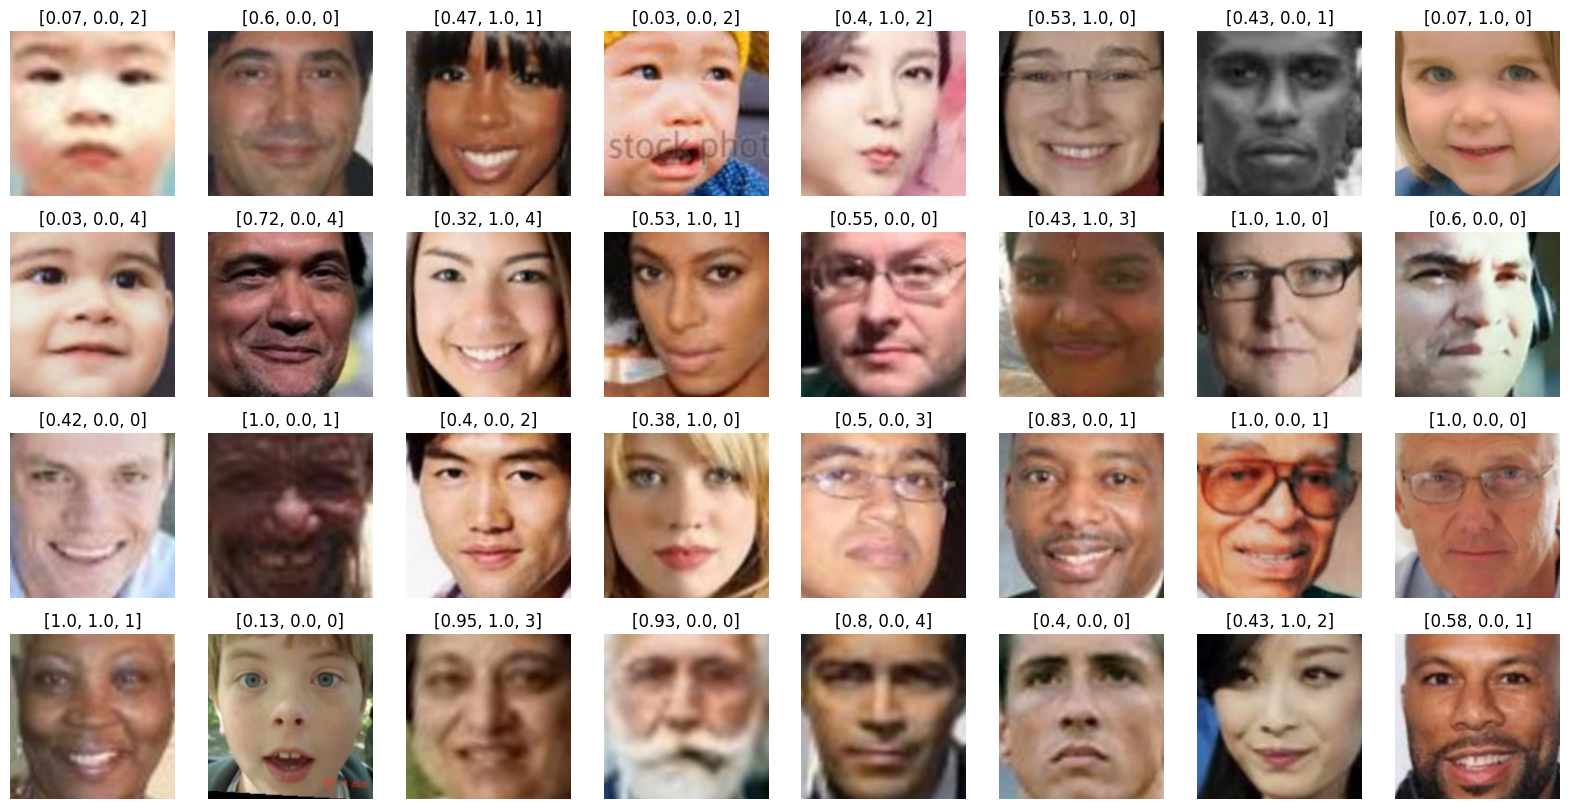

In [146]:
show_batch(dataloader=train_dl,
           transforms=rtfms_resnet34)

## Modify pretrained model
Change avpool layer to another Conv2d layer for more feature learning
Change fc to fully connected layer and add each classifier at the top

In [ ]:
# # inspect torchinfo to see original arch
# torchinfo.summary(model=model_resnet34,
#                   input_size=(32, 3, 224, 224),
#                   col_names=['input_size', 'output_size', 'num_params', 'trainable'],
#                   row_settings=['var_names'])

In [147]:
# avgpool layer accept input of (32, 512, 7, 7)
model_resnet34.avgpool = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3),
                                       nn.MaxPool2d(2),
                                       nn.ReLU(),
                                       nn.Flatten())

In [148]:
# develop AGRClassifier to replace fc
class AGRClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.intermediate = nn.Sequential(nn.Linear(2048, 512),
                                      nn.ReLU(),
                                      nn.BatchNorm1d(512),
                                      nn.Dropout(0.4),
                                      nn.Linear(512, 128),
                                      nn.ReLU(),
                                      nn.BatchNorm1d(128),
                                      nn.Dropout(0.4),
                                      nn.Linear(128, 64),
                                      nn.ReLU())
    self.age_classifier = nn.Sequential(nn.Linear(64, 1),
                                        nn.Sigmoid())
    self.gender_classifier = nn.Sequential(nn.Linear(64, 1),
                                           nn.Sigmoid())
    self.race_classifier = nn.Sequential(nn.Linear(64, 5),
                                         nn.LogSoftmax(dim=1))

  def forward(self, X):
    X = self.intermediate(X)
    age = self.age_classifier(X).squeeze()
    gender = self.gender_classifier(X).squeeze()
    race = self.race_classifier(X).squeeze()
    return age, gender, race

In [149]:
model_resnet34.fc = AGRClassifier()

In [151]:
# Developing loss_fn vs metric_fn

class AGRLossFn:
  def __init__(self):
    self.age_loss = nn.SmoothL1Loss()
    self.gender_loss = nn.BCELoss()
    self.race_loss = nn.NLLLoss()
  def __call__(self, y_logits, y):
    age_loss = self.age_loss(y_logits[0], y[0])
    gender_loss = self.gender_loss(y_logits[1], y[1])
    race_loss = self.race_loss(y_logits[2], y[2])
    return  10*age_loss + gender_loss + race_loss

loss_fn = AGRLossFn()

class AGRMetricFn:
  def __init__(self):
    self.age_metric = nn.L1Loss()
  def __call__(self, y_logits, y):
    age_metric = self.age_metric(y_logits[0], y[0]).item()*60
    gender_metric = (y_logits[1].round() == y[1]).sum().item() / len(y[1])
    race_metric = (y_logits[2].argmax(dim=1) == y[2]).sum().item() / len(y[1])
    return age_metric, gender_metric, race_metric

metric_fn = AGRMetricFn()


In [152]:
# Putting into TSEngine for training
AGRClassifier = TSEngine(model=model_resnet34,
                         optim=(torch.optim.Adam, {'lr': 1e-4}),
                         loss_fn=loss_fn,
                         train_dataloader=train_dl,
                         valid_dataloader=valid_dl,
                         metric_fn=metric_fn)

In [153]:
AGRClassifier.freeze()
AGRClassifier.unfreeze(['avgpool','fc'])

In [154]:
AGRClassifier.model_info()

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                               [32, 3, 224, 224]    [32]                 --                   Partial
├─Conv2d (conv1)                              [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                           [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                                 [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                         [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                         [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                         [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)                    [32, 64, 56, 56]     [32, 64, 56, 

Max Gradient: 1.32E-02 | Lowest Loss: 1.58E-02


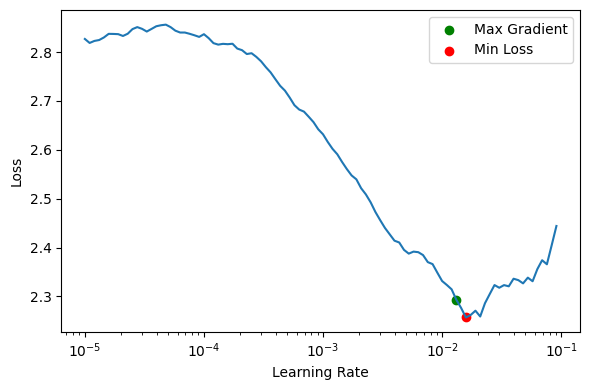

In [155]:
AGRClassifier.lr_range_test(end_lr=1e-1, start_lr=1e-5, num_iter=100)

In [156]:
AGRClassifier.fit_one_cycle(epochs=10, max_lr=2e-3, min_lr=1e-4)

Max LR: 2.0E-03 | Min LR: 1.0E-04


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | LR: 2.3E-04 | train_loss: 2.021 | valid_loss: 1.658 | train_metric: [10.298  0.719  0.515] | valid_metric: [8.724 0.791 0.605] 
Epoch: 2 | LR: 9.7E-04 | train_loss: 1.655 | valid_loss: 1.704 | train_metric: [9.294 0.794 0.617] | valid_metric: [9.057 0.804 0.576] 
Epoch: 3 | LR: 1.8E-03 | train_loss: 1.521 | valid_loss: 1.436 | train_metric: [8.655 0.818 0.649] | valid_metric: [7.456 0.809 0.677] 
Epoch: 4 | LR: 2.0E-03 | train_loss: 1.436 | valid_loss: 1.521 | train_metric: [8.337 0.834 0.671] | valid_metric: [8.457 0.839 0.651] 
Epoch: 5 | LR: 1.8E-03 | train_loss: 1.412 | valid_loss: 1.601 | train_metric: [8.359 0.832 0.682] | valid_metric: [8.703 0.8   0.655] 
Epoch: 6 | LR: 1.5E-03 | train_loss: 1.363 | valid_loss: 1.571 | train_metric: [8.207 0.843 0.696] | valid_metric: [7.314 0.842 0.697] 
Epoch: 7 | LR: 1.1E-03 | train_loss: 1.24 | valid_loss: 1.635 | train_metric: [7.796 0.863 0.722] | valid_metric: [6.999 0.854 0.721] 
Epoch: 8 | LR: 7.2E-04 | train_loss: 1.128 | v

In [157]:
AGRClassifier.save_checkpoint('UTKFace.pt')

Max Gradient: 1.45E-02 | Lowest Loss: 1.00E-05


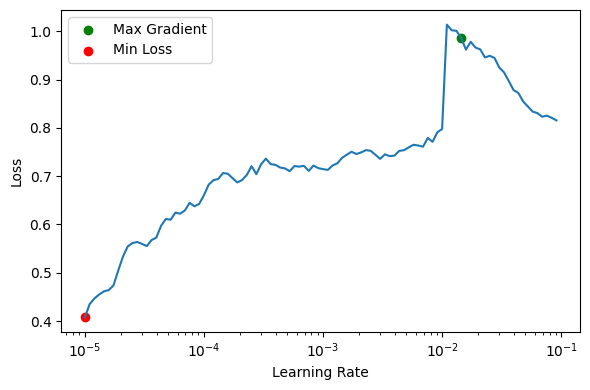

In [158]:
AGRClassifier.lr_range_test(end_lr=1e-1, start_lr=1e-5, num_iter=100)

In [161]:
AGRClassifier.load_checkpoint('UTKFace.pt')

In [162]:
AGRClassifier.set_lr(1e-4)

In [163]:
AGRClassifier.train(5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 | LR: 1.0E-04 | train_loss: 0.936 | valid_loss: 1.316 | train_metric: [7.058 0.898 0.802] | valid_metric: [6.667 0.855 0.722] 
Epoch: 12 | LR: 1.0E-04 | train_loss: 0.943 | valid_loss: 1.282 | train_metric: [6.993 0.9   0.794] | valid_metric: [6.747 0.856 0.725] 
Epoch: 13 | LR: 1.0E-04 | train_loss: 0.935 | valid_loss: 1.338 | train_metric: [7.023 0.9   0.798] | valid_metric: [6.883 0.856 0.724] 
Epoch: 14 | LR: 1.0E-04 | train_loss: 0.943 | valid_loss: 1.294 | train_metric: [7.001 0.901 0.794] | valid_metric: [6.775 0.86  0.723] 
Epoch: 15 | LR: 1.0E-04 | train_loss: 0.924 | valid_loss: 1.3 | train_metric: [6.989 0.904 0.802] | valid_metric: [6.741 0.859 0.733] 


In [164]:
AGRClassifier.save_checkpoint('UTKFace.pt')

In [165]:
# Make prediction of the valid_dataset
age = {'preds':[], 'labels': []}
gender = {'preds':[], 'labels': []}
race = {'preds':[], 'labels': []}
for batch, (X, *y) in enumerate(valid_dl):
  X = X.to('cuda')
  y_logits = AGRClassifier.predict(X)
  age['preds'] += y_logits[0].tolist()
  age['labels'] += y[0].tolist()
  gender['preds'] += y_logits[1].tolist()
  gender['labels'] += y[1].tolist()
  race['preds'] += y_logits[2].argmax(dim=1).tolist()
  race['labels'] += y[2].tolist()

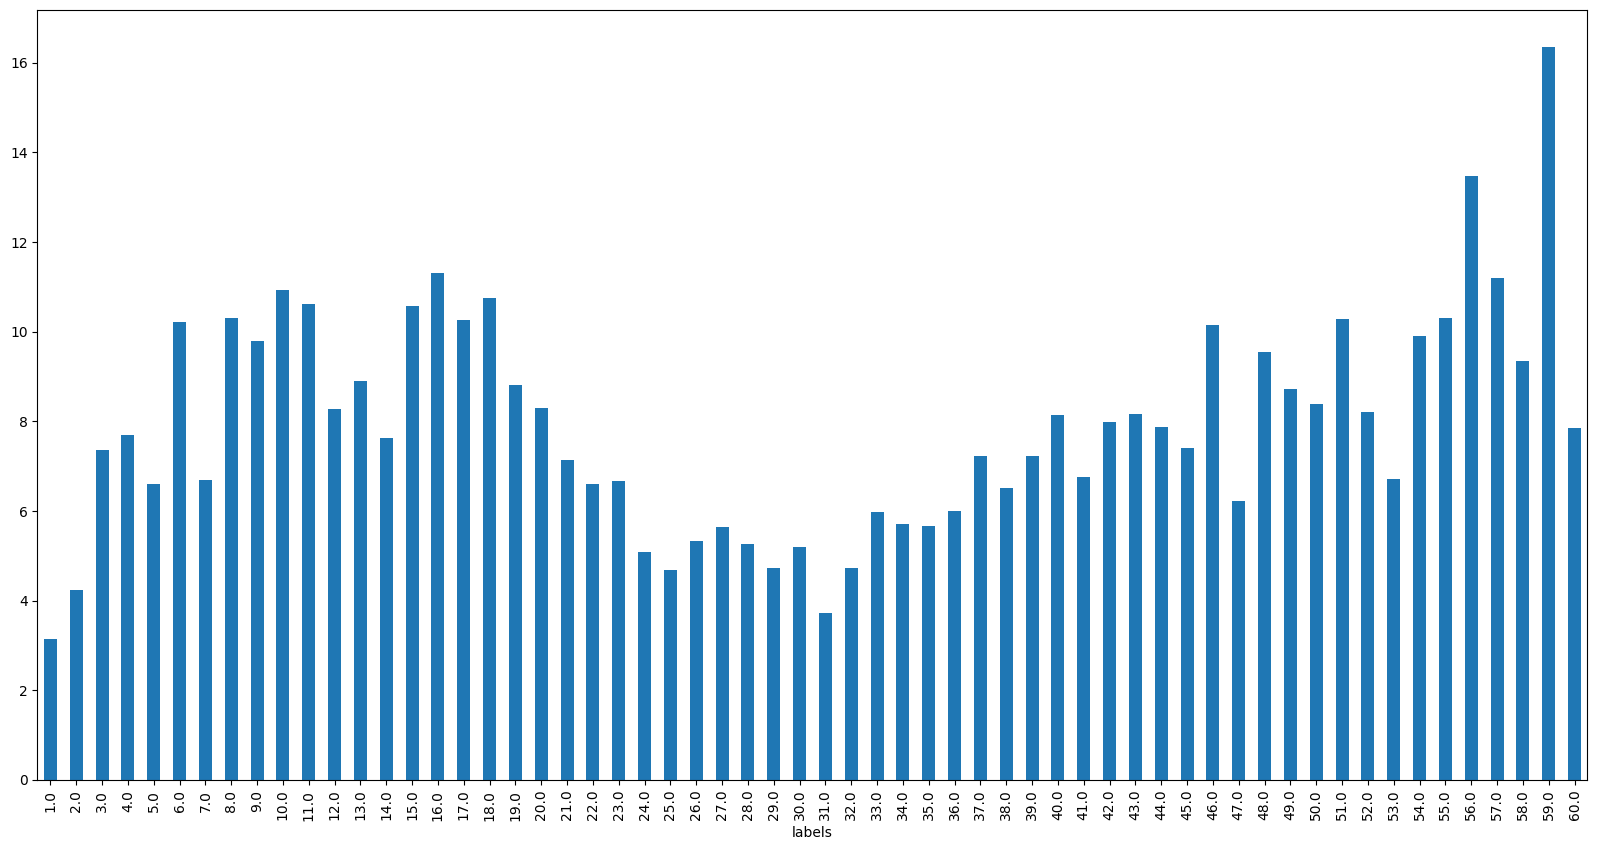

In [166]:
## Statistics of Age prediction
df_age = pd.DataFrame(age)*60
df_age['labels'] = df_age['labels'].round(0)
df_age['abs_diff'] = (df_age['preds'] - df_age['labels']).abs()
df_age.groupby('labels').mean()['abs_diff'].plot.bar(figsize=(20, 10));

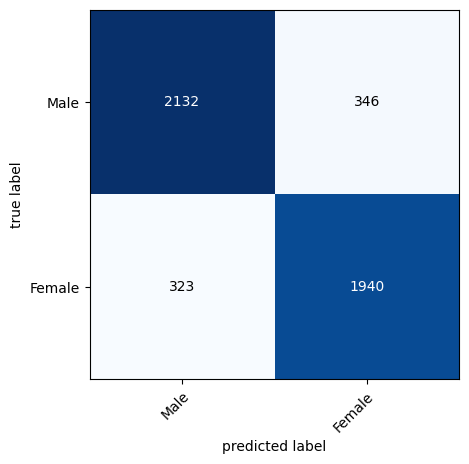

In [167]:
# Confusion matrix for gender prediction
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_gender = pd.DataFrame(gender)
df_gender['preds_results'] = df_gender['preds'].round(0)

cm = confusion_matrix(y_target=df_gender['labels'],
                      y_predicted=df_gender['preds_results'])
gender_class = ['Male', 'Female']
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=gender_class)

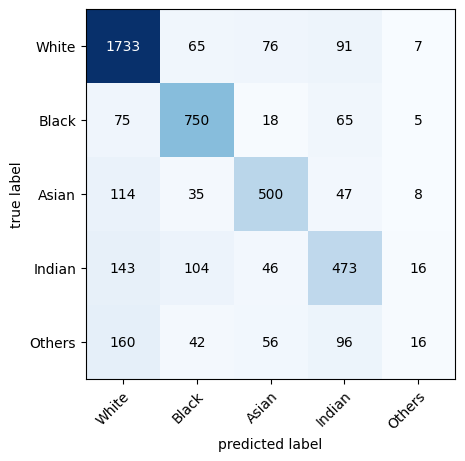

In [168]:
# Confusion matrix for gender prediction
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_race = pd.DataFrame(race)

cm = confusion_matrix(y_target=df_race['labels'],
                      y_predicted=df_race['preds'])
race_classes = ['White', 'Black', 'Asian', 'Indian', 'Others']
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=race_classes)

Downloading...
From: https://drive.google.com/uc?id=1HD6THgqvdKxO0z7EI3uAJnB9C8PUnVuD
To: /content/myself.jpg
100%|██████████| 965k/965k [00:00<00:00, 147MB/s]


'myself.jpg'

Age: 47 | Gender: Male | Race: White


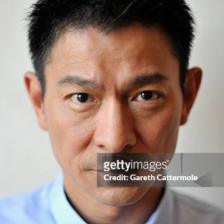

In [178]:
# Download photo
url = 'https://media.gettyimages.com/id/123985914/photo/venice-italy-actor-andy-lau-poses-at-the-a-simple-life-portrait-session-during-68th-venice.jpg?s=612x612&w=gi&k=20&c=9AqdKM2SABO_prQtsSyJIKZNETIW1mcpXdWn22iuGuU='
with open('custom.jpg', 'wb') as f:
  f.write(requests.get(url).content)

age, gender, race = AGRClassifier.predict(tfms_resnet34(Image.open('custom.jpg')).unsqueeze(dim=0).to('cuda'))
print(f'Age: {round(age.item()*80)} | Gender: {gender_class[round(gender.item())]} | Race: {race_classes[race.argmax(dim=0).item()]}')
rtfms_resnet34(tfms_resnet34(Image.open('custom.jpg')))